# Results Analysis and Visualization

**Purpose:** This notebook is for evaluating the performance of the trained Q-Learning agent against a baseline (fixed-time) controller and analyzing the training process.

### 1. Import Libraries and Load Components

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..')))

from src.simulation.environment import JammingMachine
from src.agent.q_learning_agent import QLearningAgent

### 2. Configuration

In [2]:
SIM_CONFIG_PATH = "../config/sim_config.json"
Q_TABLE_PATH = "../trained_q_table.json"
LOG_FILE_PATH = "../training_log.json"
NUM_EVALUATION_EPISODES = 50

### 3. Analyze Training Progress (The Learning Curve)

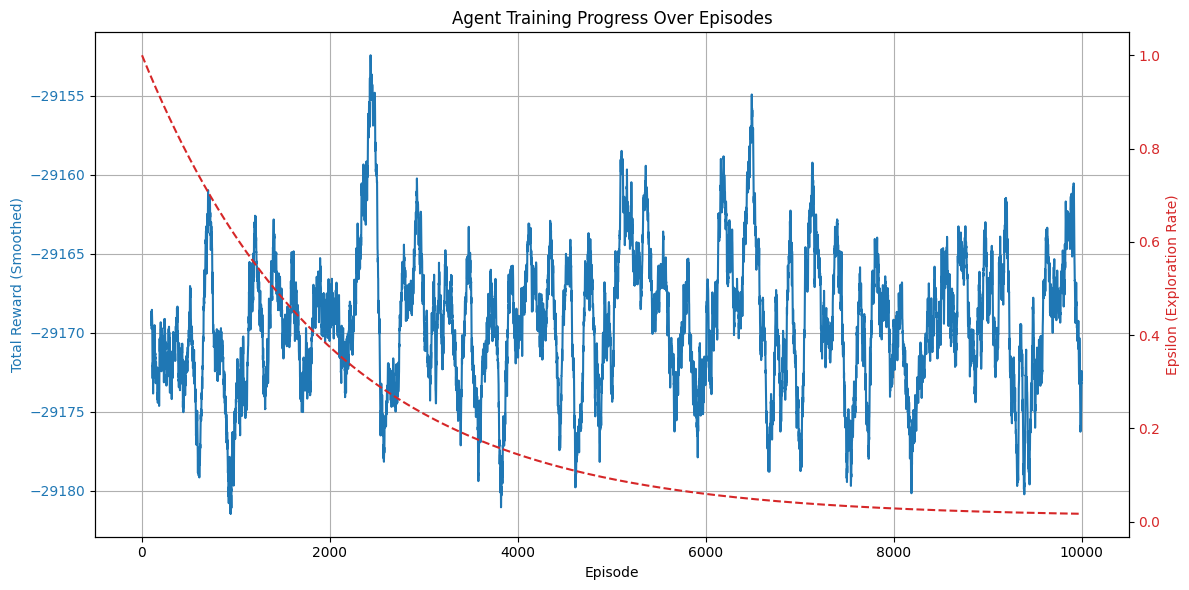

In [3]:
try:
    log_df = pd.read_json(LOG_FILE_PATH)
    
    # Calculate a moving average to smooth the curve and see the trend
    log_df['reward_moving_avg'] = log_df['total_reward'].rolling(window=100).mean()
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the smoothed reward curve
    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward (Smoothed)', color=color)
    ax1.plot(log_df['episode'], log_df['reward_moving_avg'], color=color, label='Smoothed Reward')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Create a second y-axis to show the epsilon decay
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Epsilon (Exploration Rate)', color=color)
    ax2.plot(log_df['episode'], log_df['epsilon'], color=color, linestyle='--', label='Epsilon')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('Agent Training Progress Over Episodes')
    fig.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Log file not found at {LOG_FILE_PATH}. Please run the training script first.")

### 4. Load Environment and Trained Agent for Evaluation

In [4]:
with open(SIM_CONFIG_PATH) as f:
    sim_config = json.load(f)
env = JammingMachine(sim_config)
trained_agent = QLearningAgent(state_space_size=8, action_space_size=6, learning_rate=0, discount_factor=0.95, exploration_rate=0)
trained_agent.load_q_table(Q_TABLE_PATH)
print("Environment and trained agent loaded successfully.")

TrafficModel initialized.
Jamming Machine environment initialized.
QLearningAgent initialized.
Q-table successfully loaded from ../trained_q_table.json
Environment and trained agent loaded successfully.


### 5. Define Baseline Agent and Run Evaluation

In [5]:
class FixedTimeAgent:
    def __init__(self):
        self.action_sequence = [1, 4] # Normal NS, Normal EW
        self.steps_per_action = 30
        self.current_step = 0
        self.action_index = 0
    def choose_action(self, state):
        if self.current_step > 0 and self.current_step % self.steps_per_action == 0:
            self.action_index = (self.action_index + 1) % len(self.action_sequence)
        self.current_step += 1
        return self.action_sequence[self.action_index]

def evaluate_agent(agent, environment, num_episodes):
    total_waiting_times = []
    for episode in range(num_episodes):
        state = environment.reset()
        # Reset the agent's internal state if it has one (like the fixed-time agent)
        if hasattr(agent, 'current_step'): agent.current_step = 0
        done = False
        episode_wait_time = 0
        while not done:
            action = agent.choose_action(state)
            state, reward, done, info = environment.step(action)
            episode_wait_time += sum(environment.waiting_times.values())
        total_waiting_times.append(episode_wait_time)
    return {'avg_wait_time': np.mean(total_waiting_times), 'std_wait_time': np.std(total_waiting_times)}

print("Evaluating agents...")
rl_agent_results = evaluate_agent(trained_agent, env, NUM_EVALUATION_EPISODES)
baseline_agent = FixedTimeAgent()
baseline_results = evaluate_agent(baseline_agent, env, NUM_EVALUATION_EPISODES)
print("Evaluation complete.")

Evaluating agents...
Evaluation complete.


### 6. Display and Plot Final Comparison

--- PERFORMANCE COMPARISON ---
Metric: Average Total Waiting Time per Episode (Lower is better)
  - Trained RL Agent: 8,574,369.40 (+/- 27,049.24)
  - Baseline Agent:   8,562,054.98 (+/- 29,115.73)

Improvement by RL Agent: -0.14%
-----------------------------


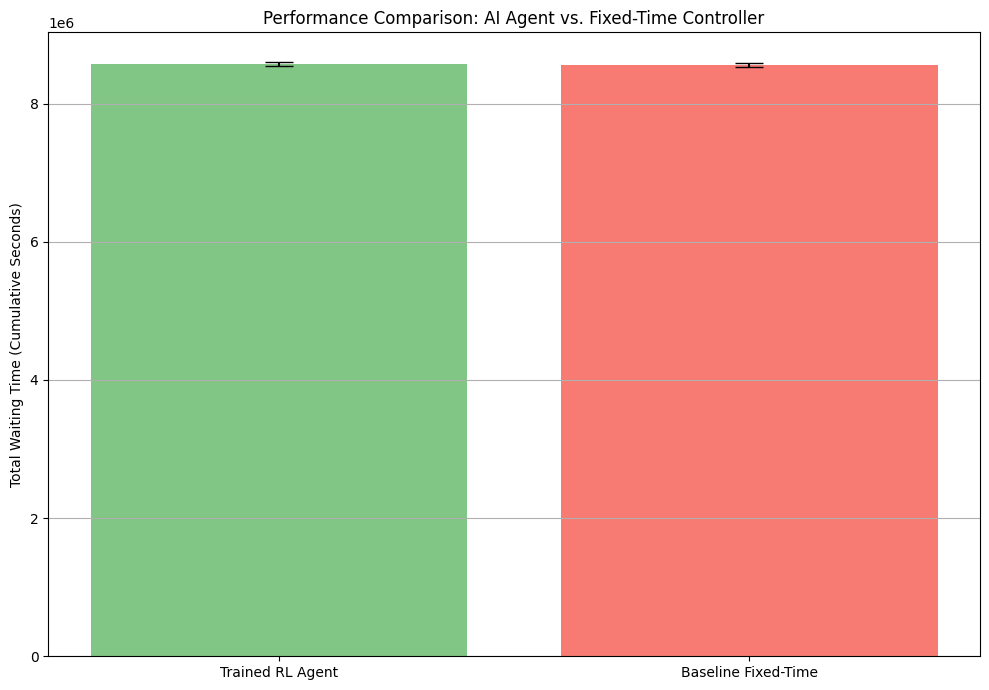

In [6]:
print("--- PERFORMANCE COMPARISON ---")
print(f"Metric: Average Total Waiting Time per Episode (Lower is better)")
print(f"  - Trained RL Agent: {rl_agent_results['avg_wait_time']:,.2f} (+/- {rl_agent_results['std_wait_time']:,.2f})")
print(f"  - Baseline Agent:   {baseline_results['avg_wait_time']:,.2f} (+/- {baseline_results['std_wait_time']:,.2f})")
improvement = (baseline_results['avg_wait_time'] - rl_agent_results['avg_wait_time']) / baseline_results['avg_wait_time'] * 100
print(f"\nImprovement by RL Agent: {improvement:.2f}%")
print("-----------------------------")

labels = ['Trained RL Agent', 'Baseline Fixed-Time']
means = [rl_agent_results['avg_wait_time'], baseline_results['avg_wait_time']]
stds = [rl_agent_results['std_wait_time'], baseline_results['std_wait_time']]

fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(labels, means, yerr=stds, align='center', alpha=0.7, ecolor='black', capsize=10, color=['#4CAF50', '#F44336'])
ax.set_ylabel('Total Waiting Time (Cumulative Seconds)')
ax.set_title('Performance Comparison: AI Agent vs. Fixed-Time Controller')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()